# Uso avanzado de los valores SHAP

## EJERCICIOS

## Configuración

A continuación se proporciona el código para realizar la carga básica, la revisión y la creación de modelos. Ejecuta la celda de abajo para configurar todo:

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap

%matplotlib inline

data = pd.read_csv('./data/hospital-readmissions/train.csv')
y = data.readmitted
base_features = ['number_inpatient', 'num_medications', 'number_diagnoses', 'num_lab_procedures', 
                 'num_procedures', 'time_in_hospital', 'number_outpatient', 'number_emergency', 
                 'gender_Female', 'payer_code_?', 'medical_specialty_?', 'diag_1_428', 'diag_1_414', 
                 'diabetesMed_Yes', 'A1Cresult_None']

# Some versions of shap package error when mixing bools and numerics
X = data[base_features].astype(float)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# For speed, we will calculate shap values on smaller subset of the validation data
small_val_X = val_X.iloc[:150]
my_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(train_X, train_y)

In [3]:
data.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000
mean,4.395640,42.96012,1.341080,15.988440,0.365920,0.203280,0.64300,7.420160,0.456400
std,2.991165,19.76881,1.705398,8.107743,1.224419,0.982973,1.26286,1.940932,0.498105
min,1.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000
25%,2.000000,31.00000,0.000000,10.000000,0.000000,0.000000,0.00000,6.000000,0.000000
50%,4.000000,44.00000,1.000000,15.000000,0.000000,0.000000,0.00000,8.000000,0.000000
75%,6.000000,57.00000,2.000000,20.000000,0.000000,0.000000,1.00000,9.000000,1.000000
max,14.000000,126.00000,6.000000,81.000000,36.000000,64.000000,21.00000,16.000000,1.000000


Las primeras preguntas requieren examinar la distribución de los efectos para cada característica, en lugar de solo un efecto promedio para cada característica. Ejecuta la siguiente celda para obtener un gráfico de resumen de los valores shap para la readmisión. Tardará unos 20 segundos en ejecutarse.

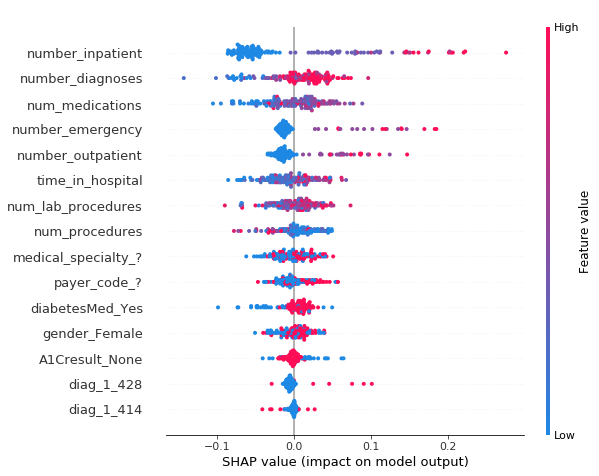

In [4]:
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(small_val_X)

shap.summary_plot(shap_values[1], small_val_X)

## Pregunta 1

¿Cuál de las siguientes características tiene un mayor rango de efectos en las predicciones (es decir, mayor diferencia entre el efecto más positivo y el más negativo)?
- `diag_1_428` o
- `payer_code_?`

***Solución:*** diag_1_428

## Pregunta 2

¿Cree que la gama de tamaños de efectos (distancia entre el efecto más pequeño y el efecto más grande) es una buena indicación de qué característica tendrá una mayor importancia en la permutación? ¿Por qué o por qué no?

Si el **rango de tamaños de efecto** mide algo diferente de **la importancia de la permutación**: cuál es la mejor respuesta para la pregunta "¿Cuál de estas dos características dice el modelo que es más importante que entendamos al analizar los riesgos de readmisión en la población?"

***Solución***: No. El ancho del rango de efectos no es una aproximación razonable a la importancia de la permutación. En este sentido, el ancho del rango no se corresponde bien a ningún sentido intuitivo de "importancia" porque puede ser determinado por unos pocos valores atípicos. Sin embargo, si todos los puntos en el gráfico están muy separados entre sí, eso es una indicación razonable de que la importancia de la permutación es alta. Debido a que el rango de efectos es tan sensible a los valores atípicos, la importancia de la permutación es una mejor medida de lo que generalmente es importante para el modelo.

## Pregunta 3

Tanto `diag_1_428` como `payer_code_?` Son variables binarias, tomando valores de 0 o 1.

En la gráfica, ¿cuál crees que normalmente tendría un mayor impacto en el riesgo de reingreso previsto?
- Cambiando `diag_1_428` de 0 a 1
- Cambiando `payer_code_?` De 0 a 1

***Solución***: `diag_1_428`. Mientras que la mayoría de los valores SHAP de diag_1_428 son pequeños, los pocos puntos rosados (valores altos de la variable, correspondientes a las personas con ese diagnóstico) tienen valores SHAP grandes. En otras palabras, los puntos rosados para esta variable están lejos de ser 0, y hacer que alguien tenga el valor más alto (rosa) aumentaría significativamente el riesgo de reingreso. En términos del mundo real, este diagnóstico es raro, pero representa un riesgo mayor para las personas que lo tienen. En contraste, payer_code_? tiene muchos valores de azul y rosa, y ambos tienen valores SHAP que difieren significativamente de 0. Pero cambiar payer_code_? de 0 (azul) a 1 (rosa) es probable que tenga un impacto menor que el cambio de diag_1_428.

## Pregunta 4

Algunas características (como `number_inpatient`) tienen una separación razonablemente clara entre los puntos azules y rosados. Otras variables como `num_lab_procedures` tienen puntos azules y rosas mezclados, aunque los valores SHAP (o los impactos en la predicción) no son todos 0.

¿Qué crees que aprendes del hecho de que `num_lab_procedures` tiene puntos azules y rosas mezclados?

***Solución***: El desorden sugiere que algunas veces aumentar esa característica conduce a predicciones más altas y otras veces conduce a una predicción más baja. Dicho de otra manera, tanto los valores altos como bajos de la característica pueden tener efectos positivos y negativos en la predicción. La explicación más probable para este "embrollo" de efectos es que la variable (en este caso, `num_lab_procedures`) tiene un efecto de interacción con otras variables. Por ejemplo, puede haber algunos diagnósticos para los cuales es bueno tener muchos procedimientos de laboratorio y otros diagnósticos donde se sugiere un mayor riesgo. Aún no sabemos qué otra característica está interactuando con `num_lab_procedures`, aunque podríamos investigar eso con los gráficos de dependencia de contribución SHAP.

## Pregunta 5

Consideremos la siguiente gráfica de dependencia de contribución SHAP.

El eje x muestra `feature_of_interest` y los puntos están coloreados en función de `other_feature`.

![Imgur](https://i.imgur.com/zFdHneM.png)

¿Hay una interacción entre `feature_of_interest` y `other_feature`?

Si es así, ¿tiene `feature_of_interest` un impacto más positivo en las predicciones cuando `other_feature` es alto o cuando `other_feature` es bajo?

***Solución***: Primero, recuerde que el valor de SHAP es una estimación del impacto de una característica dada en la predicción. Por lo tanto, si los puntos tienden desde la parte superior izquierda a la inferior derecha, eso significa que los valores bajos de `feature_of_interest` causan predicciones más altas.

Volviendo a este gráfico:

`feature_of_interest` se inclina hacia abajo para valores altos de `other_feature`. Para ver esto, enfoca tu ojo en los puntos rosados (donde `other_feature` es alta) e imagina una línea de mejor ajuste a través de esos puntos rosados. Se inclina hacia abajo, lo que sugiere que la predicción disminuye a medida que aumenta `feature_of_interest`.

Ahora enfoca tu ojo en los puntos azules e imagina una línea de mejor ajuste a través de esos puntos. Generalmente es bastante plano, posiblemente incluso curvándose hacia arriba en el lado derecho de la gráfica. Por lo tanto, el aumento de `feature_of_interest` tiene un impacto más positivo en las predicciones cuando `other_feature` es alto.

## Pregunta 6

Revisa el diagrama de resumen para los datos de readmisión ejecutando la siguiente celda:

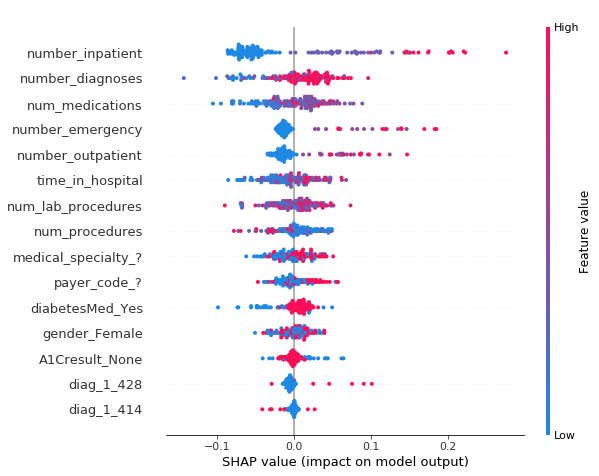

In [5]:
shap.summary_plot(shap_values[1], small_val_X)

Tanto **num_medications** como **num_lab_procedures** comparten esa mezcla de puntos rosados y azules.

Aparte de que `num_medications` tiene efectos de mayor magnitud (tanto más positivos como más negativos), es difícil ver una diferencia significativa entre cómo estas dos características afectan el riesgo de readmisión. Cree las gráficas de contribución de dependencia SHAP para cada variable y describa qué cree que es diferente entre cómo estas dos variables afectan las predicciones.

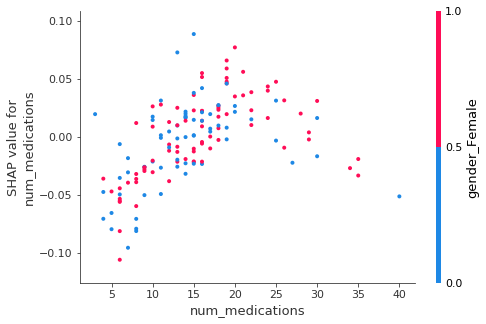

In [6]:
shap.dependence_plot("num_medications", shap_values[1], small_val_X)

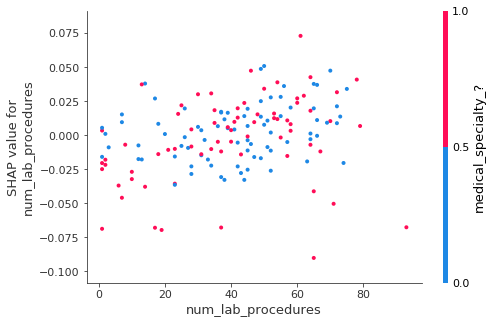

In [7]:
shap.dependence_plot("num_lab_procedures", shap_values[1], small_val_X)

En términos generales, `num_lab_procedures` se parece a una nube con un patrón poco discernible. No se inclina hacia arriba ni hacia abajo en ningún punto. Es difícil decir que hemos aprendido algo de este gráfico. Al mismo tiempo, los valores no son todos muy cercanos a 0. Así que el modelo parece pensar que esta es una característica relevante. Un próximo paso potencial sería explorar más coloreando con otras características diferentes para buscar una interacción.

Por otro lado, `num_medications` claramente se inclina hacia arriba hasta un valor de alrededor de 20, y luego vuelve a bajar. Sin más antecedentes médicos, esto parece un fenómeno sorprendente ... Podrías hacer un poco de exploración para ver si estos pacientes tienen valores inusuales para otras características también. Pero un buena manera de continuar sería discutir este fenómeno con expertos en el dominio (en este caso, los médicos).

## Felicidades

¡Eso es! Los modelos de machine learning ya no deben sentirse como cajas negras, porque tienes las herramientas para inspeccionarlos y comprender lo que aprenden sobre el mundo.

Esta es una excelente habilidad para depurar modelos, generar confianza y descubrir insights para tomar mejores decisiones. Estas técnicas han revolucionado la forma en que hago ciencia de datos y espero que hagan lo mismo por ti.

La ciencia de datos reales implica un elemento de exploración. Espero que encuentres un conjunto de datos interesante para probar estas técnicas (Kaggle tiene muchos [conjuntos de datos gratuitos](https://www.kaggle.com/datasets) para probar). Si aprendes algo interesante sobre el mundo, comparte tu trabajo [en este foro](https://www.kaggle.com/learn-forum/66354). Estoy emocionado de ver lo que haces con tus nuevas habilidades.